In [1]:
import pandas as pd
import numpy as np
import os
import json
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # This is perfect for Z-score normalisation
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
from scipy import stats




In [2]:
PROMPT_VERSIONS = 3
QUESTION_INDICES = [0,3]
LLM_VERSION = "41-mini"  # Change this to the desired LLM name
REPETITIONS = 5


QUESTIONS = [
    "Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben",
    "Deutschland soll seine Verteidigungsausgaben erhöhen",
    "Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen.",
    "Die Förderung von Windenergie soll beendet werden.",
    "Die Möglichkeiten der Vermieterinnen und Vermieter, Wohnungsmieten zu erhöhen, sollen gesetzlich stärker begrenzt werden.",
]

QUESTIONS_SHORT = [
    "Tempolimit",
    "Verteidigungsausgaben",
    "Wahlrecht ab 16",
    "Windenergie",
    "Mietpreisbremse",
]

In [3]:
# open dir ../configs
# Get the current working directory of the notebook
notebook_path = os.getcwd()

# Collect all answer DataFrames for each version and repetition
n_questions = len(QUESTIONS)
all_answers_versions = pd.DataFrame()
json_files_versions = [[] for _ in range(PROMPT_VERSIONS * n_questions)]

for question_index in QUESTION_INDICES:

    config_path = os.path.join(notebook_path, f"../config/question_{question_index}")
    print(config_path)
    # get name of all subdirectories in ../configs
    subdirs = [
        d
        for d in os.listdir(config_path)
        if os.path.isdir(os.path.join(config_path, d))
    ]
    for subdir in subdirs:
        subdir_path = os.path.join(config_path, subdir)
        config_file = os.path.join(subdir_path, "config_0.json")
        try:
            with open(config_file, "r") as file:
                config_data = json.load(file)
            config_df = pd.json_normalize(config_data)
            party_1 = config_df["persons"][0][0]["party"]
            party_2 = config_df["persons"][0][1]["party"]
            name_1 = config_df["persons"][0][0]["name"]
            name_2 = config_df["persons"][0][1]["name"]
        except Exception as e:
            print(f"Error reading {config_file}: {e}")
            continue
        for v in range(PROMPT_VERSIONS):
            for repetition in range(REPETITIONS):
                json_file = os.path.join(
                    subdir_path, f"out_{LLM_VERSION}_v{v}_{repetition}.json"
                )
                if os.path.isfile(json_file):
                    json_files_versions[v].append(json_file)
                else:
                    continue
                try:
                    with open(json_file, "r") as file:
                        data = json.load(file)
                except Exception as e:
                    print(f"Error reading {json_file}: {e}")
                    continue
                columns = {}
                columns["question_index"] = question_index
                columns["party_1"] = party_1
                columns["party_2"] = party_2
                columns["repetition"] = repetition
                columns["version"] = v
                for q in data["survey_question"]:
                    name = q["chat_entry"]["entity"]["name"]
                    name = "agent_1" if name == name_1 else "agent_2"
                    iteration = q["iteration"]
                    col_name = f"{name}_T{iteration}"
                    columns[col_name] = q["chat_entry"]["answer"]
                answers_df = pd.DataFrame([columns])

                all_answers_versions = pd.concat([all_answers_versions, answers_df], ignore_index=True)


display(all_answers_versions)

print(f"length of all_answers_versions: {len(all_answers_versions)}")


/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/question_0
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/question_3


,question_index,party_1,party_2,repetition,version,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,0,CDU/CSU,AfD,0,0,4,3,5,3,6,3,6,3,6,3,6,3
1,0,CDU/CSU,AfD,1,0,4,3,5,3,6,3,6,3,5,3,6,3
2,0,CDU/CSU,AfD,2,0,4,3,6,3,5,3,5,3,6,3,5,3
3,0,CDU/CSU,AfD,3,0,4,3,5,3,5,3,6,3,6,4,5,4
4,0,CDU/CSU,AfD,4,0,4,3,5,5,5,6,5,6,5,6,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,3,FDP,CDU/CSU,0,2,2,4,1,2,1,2,1,2,1,1,1,2
836,3,FDP,CDU/CSU,1,2,1,4,1,2,1,2,1,1,1,1,1,1
837,3,FDP,CDU/CSU,2,2,2,5,1,2,1,1,1,2,1,2,1,1
838,3,FDP,CDU/CSU,3,2,2,4,1,1,1,1,1,1,1,1,1,1


length of all_answers_versions: 840


In [4]:
# Helper function to process big_df into long format with agent_idx
def process_big_df(big_df: pd.DataFrame) -> pd.DataFrame:
    t_row = ["party", "debate_with", "repetition"]
    formatted_df = pd.DataFrame(columns=t_row)
    for row in big_df.iterrows():
        party_1 = row[1]["party_1"]
        party_2 = row[1]["party_2"]
        prompt_version = int(row[1]["version"])
        repetition = int(row[1]["repetition"])
        question_index = int(row[1]["question_index"])

        # agent_1 row
        agent_1_data = row[1].filter(like="agent_1")
        agent_1_data.index = agent_1_data.index.str.replace("agent_1_", "")
        agent_1_data = agent_1_data.rename(party_1)
        agent_1_data = agent_1_data.to_frame().T
        agent_1_data.insert(0, "debate_with", party_2)
        agent_1_data.insert(0, "party", party_1)
        agent_1_data.insert(0, "repetition", repetition)
        agent_1_data.insert(0, "version", prompt_version)
        agent_1_data.insert(0, "question_index", question_index)
        formatted_df = pd.concat([formatted_df, agent_1_data], ignore_index=True)
        # agent_2 row
        agent_2_data = row[1].filter(like="agent_2")
        agent_2_data.index = agent_2_data.index.str.replace("agent_2_", "")
        agent_2_data = agent_2_data.rename(party_2)
        agent_2_data = agent_2_data.to_frame().T
        agent_2_data.insert(0, "debate_with", party_1)
        agent_2_data.insert(0, "party", party_2)
        agent_2_data.insert(0, "repetition", repetition)
        agent_2_data.insert(0, "version", prompt_version)
        agent_2_data.insert(0, "question_index", question_index)
        formatted_df = pd.concat([formatted_df, agent_2_data], ignore_index=True)
    
    formatted_df = formatted_df.reset_index(drop=True)
    for col in formatted_df.columns:
        if col.startswith("T"):

            def extract_number(text):
                if pd.isna(text):
                    return None
                if isinstance(text, (int, float)):
                    return text
                text = str(text)
                numbers = re.findall(r"\d+", text)
                if numbers:
                    return int(numbers[0])
                else:
                    return None

            formatted_df[col] = formatted_df[col].apply(extract_number)

    

    return formatted_df


formatted_df = process_big_df(all_answers_versions)
display(formatted_df)

,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20
0,CDU/CSU,AfD,0,0.0,0.0,4,5,6,6,6,6
1,AfD,CDU/CSU,0,0.0,0.0,3,3,3,3,3,3
2,CDU/CSU,AfD,1,0.0,0.0,4,5,6,6,5,6
3,AfD,CDU/CSU,1,0.0,0.0,3,3,3,3,3,3
4,CDU/CSU,AfD,2,0.0,0.0,4,6,5,5,6,5
...,...,...,...,...,...,...,...,...,...,...,...
1675,CDU/CSU,FDP,2,3.0,2.0,5,2,1,2,2,1
1676,FDP,CDU/CSU,3,3.0,2.0,2,1,1,1,1,1
1677,CDU/CSU,FDP,3,3.0,2.0,4,1,1,1,1,1
1678,FDP,CDU/CSU,4,3.0,2.0,2,1,1,1,1,1


In [5]:
formatted_df_non_abs = formatted_df.copy()
party_df_non_abs = formatted_df_non_abs.melt(
    id_vars=["party", "debate_with", "version", "question_index", "repetition"],
    var_name="time",
    value_name="answer",
)
party_df_non_abs = party_df_non_abs.dropna(subset=["answer"]).reset_index(drop=True)
display(party_df_non_abs)



,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,T0,4
1,AfD,CDU/CSU,0.0,0.0,0,T0,3
2,CDU/CSU,AfD,0.0,0.0,1,T0,4
3,AfD,CDU/CSU,0.0,0.0,1,T0,3
4,CDU/CSU,AfD,0.0,0.0,2,T0,4
...,...,...,...,...,...,...,...
10075,CDU/CSU,FDP,2.0,3.0,2,T20,1
10076,FDP,CDU/CSU,2.0,3.0,3,T20,1
10077,CDU/CSU,FDP,2.0,3.0,3,T20,1
10078,FDP,CDU/CSU,2.0,3.0,4,T20,1


10080
Index(['party', 'debate_with', 'version', 'question_index', 'repetition',
       'time', 'answer'],
      dtype='object')


,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,T0,4
1,AfD,CDU/CSU,0.0,0.0,0,T0,3
2,CDU/CSU,AfD,0.0,0.0,1,T0,4
3,AfD,CDU/CSU,0.0,0.0,1,T0,3
4,CDU/CSU,AfD,0.0,0.0,2,T0,4
...,...,...,...,...,...,...,...
10075,CDU/CSU,FDP,2.0,3.0,2,T20,1
10076,FDP,CDU/CSU,2.0,3.0,3,T20,1
10077,CDU/CSU,FDP,2.0,3.0,3,T20,1
10078,FDP,CDU/CSU,2.0,3.0,4,T20,1


QUESION_INDICES: [0 3]   
Plotting question index 0


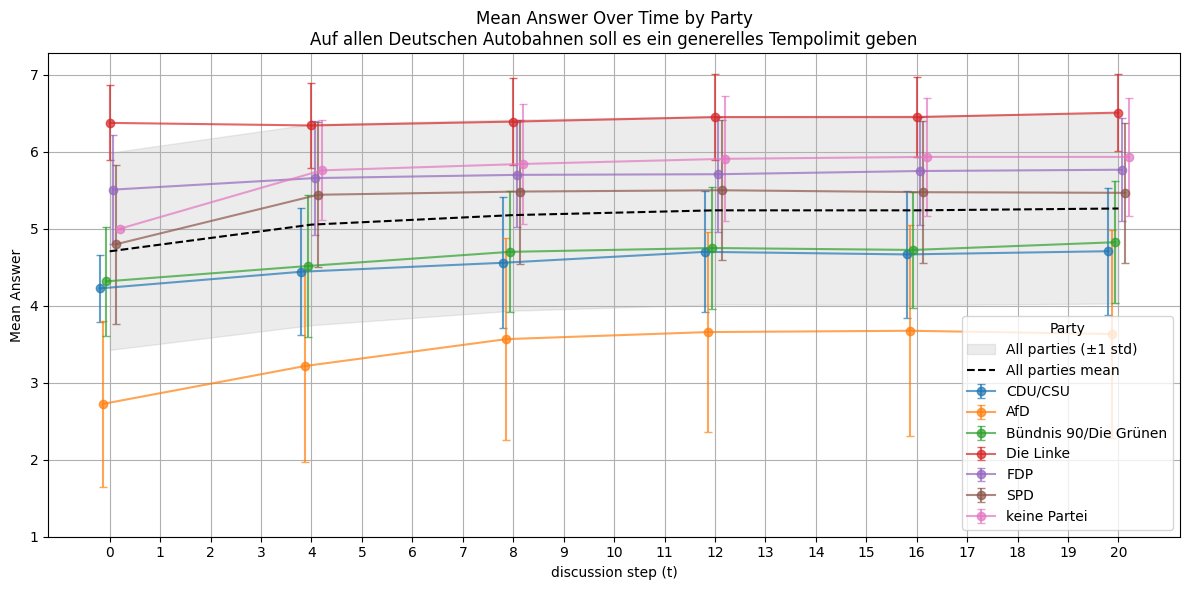

Plotting question index 3


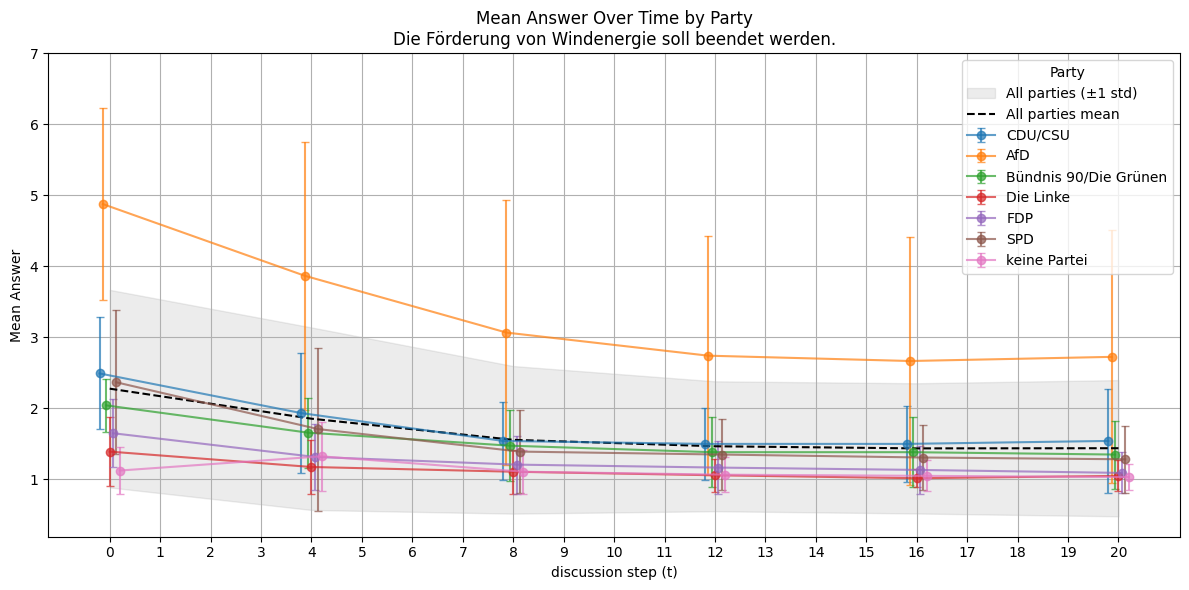

In [6]:
plot_df = party_df_non_abs.copy()


print(len(plot_df))
print(plot_df.columns)

display(plot_df)
plot_df["time"] = plot_df["time"].str.replace("T", "").astype(int)
plot_df["question_index"] = plot_df["question_index"].astype(int)
plot_df["repetition"] = plot_df["repetition"].astype(int)
plot_df = plot_df[(plot_df["answer"] <= 7) & (plot_df["answer"] >= 1)]
plot_df["answer"] = pd.to_numeric(plot_df["answer"], errors="coerce")

parties = list(plot_df["party"].unique())
offsets = np.linspace(-0.2, 0.2, len(parties))  # For party errorbars

print(f"QUESION_INDICES: {plot_df["question_index"].unique()}   ")

for question in plot_df["question_index"].unique():
    print(f"Plotting question index {question}")
    plt.figure(figsize=(12, 6))
    # Plot per-party errorbars, slightly offset
    for i, party in enumerate(parties):
        party_data = plot_df[
            (plot_df["party"] == party) & (plot_df["question_index"] == question)
        ]
        means = party_data.groupby("time")["answer"].mean()
        stds = party_data.groupby("time")["answer"].std()
        x = means.index + offsets[i]
        plt.errorbar(
            x,
            means.values,
            yerr=stds.values,
            marker="o",
            label=f"{party}",
            capsize=3,
            alpha=0.7,
        )
    # Plot overall mean and std as a field (no offset)
    all_data = plot_df[plot_df["question_index"] == question]
    all_means = all_data.groupby("time")["answer"].mean()
    all_stds = all_data.groupby("time")["answer"].std()
    plt.fill_between(
        all_means.index,
        all_means - all_stds,
        all_means + all_stds,
        color="gray",
        alpha=0.15,
        label="All parties (±1 std)",
    )
    plt.plot(
        all_means.index,
        all_means.values,
        color="black",
        linestyle="--",
        label="All parties mean",
    )
    plt.title(f"Mean Answer Over Time by Party\n{QUESTIONS[question]}")
    plt.xticks(range(0, 21))
    plt.yticks(range(1, 8))
    plt.xlabel("discussion step (t)")
    plt.ylabel("Mean Answer")
    plt.legend(title="Party")
    plt.grid()
    plt.tight_layout()
    plt.show()

Plotting for question 0: Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben


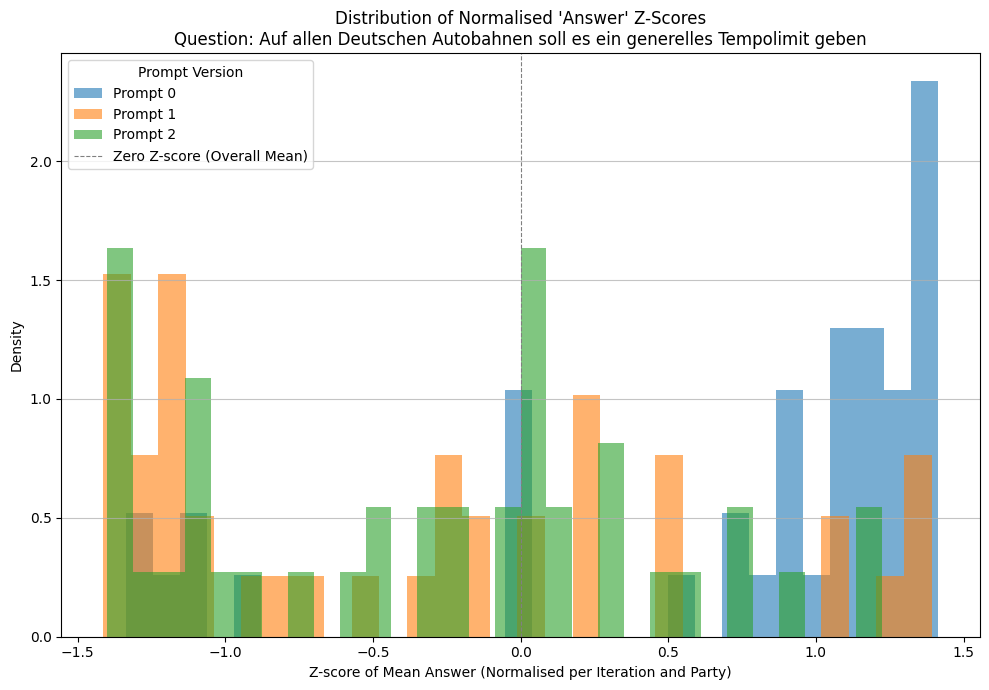

Plotting for question 3: Die Förderung von Windenergie soll beendet werden.


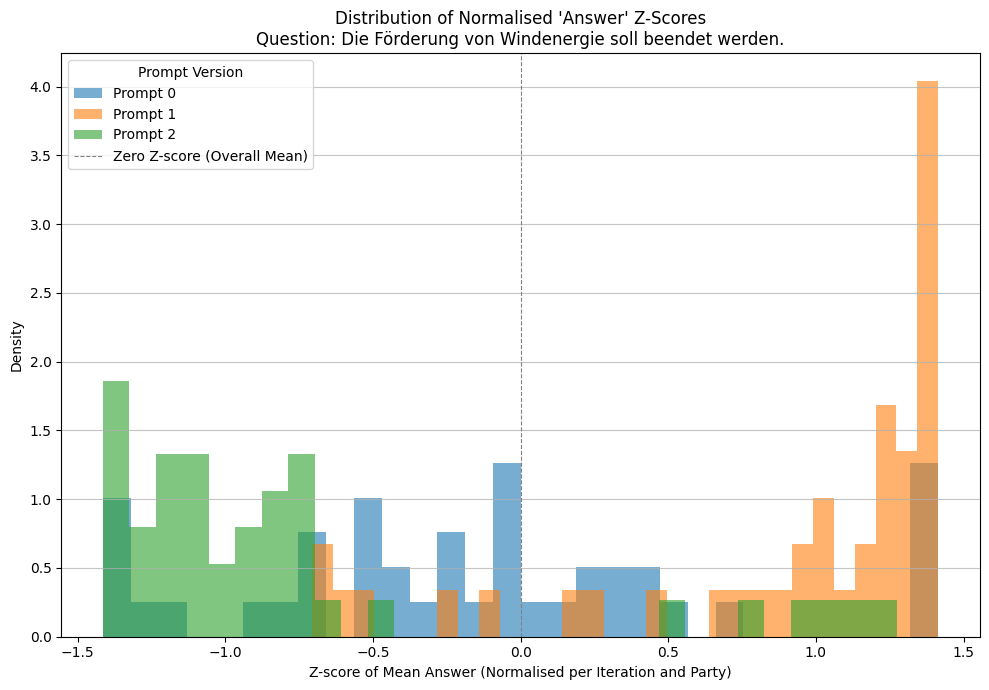

In [7]:
prompt_labels = {
    0: "Prompt 0",
    1: "Prompt 1",
    2: "Prompt 2"
}

for question in plot_df["question_index"].unique():
    print(f"Plotting for question {question}: {QUESTIONS[int(question)]}")

    # Aggregate means per repetition, party, version for this question
    aggregated_means = plot_df[plot_df["question_index"] == question].groupby(
        ["time", "party", "version"]
    )["answer"].mean().reset_index()
    aggregated_means.rename(columns={"answer": "mean_answer"}, inplace=True)

    # Normalise per time and party
    normalised_df = pd.DataFrame()
    for time in aggregated_means["time"].unique():
        for party in aggregated_means["party"].unique():
            iteration_data = aggregated_means[
                (aggregated_means["time"] == time)
                & (aggregated_means["party"] == party)
            ].copy()
            scaler = StandardScaler()
            iteration_data["z_score"] = scaler.fit_transform(iteration_data[["mean_answer"]])
            normalised_df = pd.concat([normalised_df, iteration_data])

    plt.figure(figsize=(10, 7))
    versions_sorted = sorted(normalised_df["version"].unique())
    for version_str in versions_sorted:
        prompt_v = int(version_str)
        version_data = normalised_df[normalised_df["version"] == version_str]
        plt.hist(
            version_data["z_score"],
            bins=30,
            alpha=0.6,
            label=prompt_labels[prompt_v],
            density=True,
            histtype='stepfilled'
        )
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8, label='Zero Z-score (Overall Mean)')
    plt.title(f"Distribution of Normalised 'Answer' Z-Scores\nQuestion: {QUESTIONS[int(question)]}")
    plt.xlabel("Z-score of Mean Answer (Normalised per Iteration and Party)")
    plt.ylabel("Density")
    plt.legend(title="Prompt Version")
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()


```


For each question:
    Z0 = []
    Z1 = []
    Z2 = []

    For each Timestep:
        For each Party:
            data = Data(question, timestep, party)
            scaler = Scaler(data)

            mean_v0 = data(version = 0)
            mean_v1 = data(version = 1)
            mean_v2 = data(version = 2)

            Z0.append = scaler.apply(mean_0)
            Z1.append = scaler.apply(mean_1)
            Z2.append = scaler.apply(mean_2)


    Histogram(Z0,Z1,Z2)
```


    

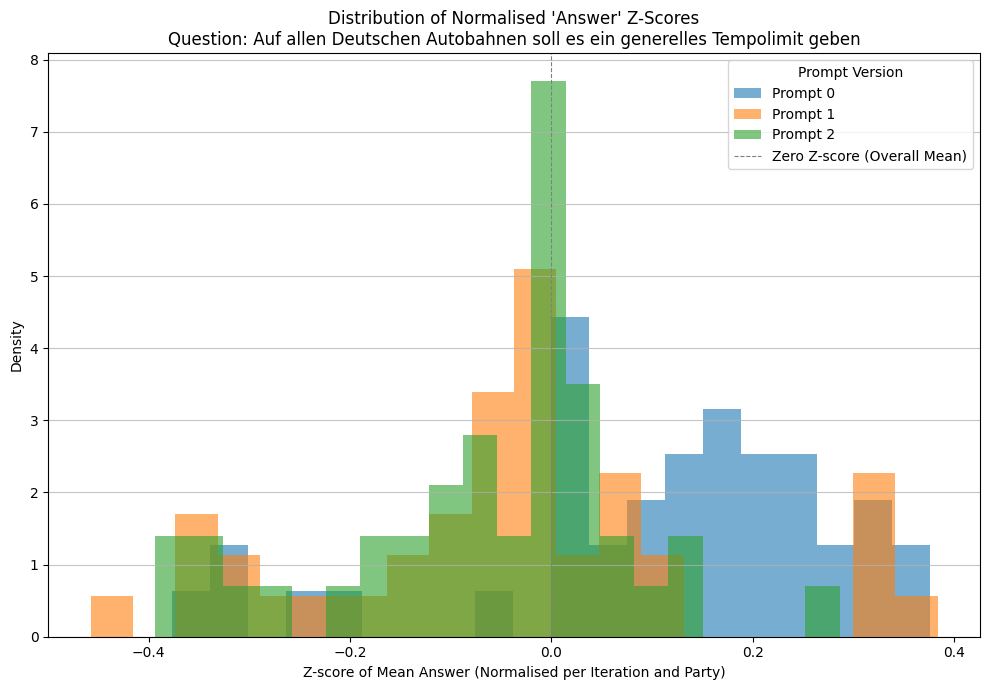

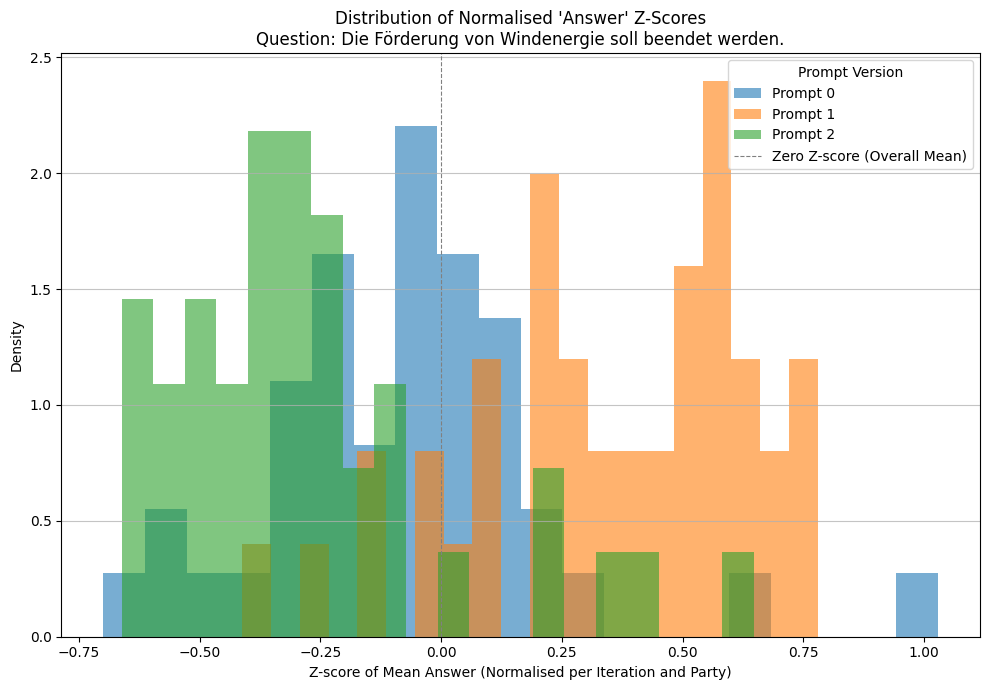

In [8]:
prompt_labels = {
    0: "Prompt 0",
    1: "Prompt 1",
    2: "Prompt 2"
}

for question in plot_df["question_index"].unique():
    normalised_df = {0: [], 1: [], 2: []}
    aggregated_means = plot_df[plot_df["question_index"] == question].copy()


    for time in aggregated_means["time"].unique():
        for party in aggregated_means["party"].unique():
            iteration_data = aggregated_means[
                 (aggregated_means["time"] == time)
                & (aggregated_means["party"] == party)
                
            ].copy()
            scaler = StandardScaler()
            scaler.fit(iteration_data[["answer"]].values.reshape(-1, 1))
            for prompt_v in range(3):
                mean = np.mean(
                    iteration_data[iteration_data["version"] == prompt_v]["answer"]
                )
                z_score = scaler.transform(np.array([[mean]]))[0][0]
                normalised_df[prompt_v].append(z_score)

    plt.figure(figsize=(10, 7))
    versions_sorted = sorted(normalised_df.keys())
    for version_str in versions_sorted:
        prompt_v = version_str
        version_data = normalised_df[prompt_v]
        plt.hist(
            version_data,
            bins=20,
            alpha=0.6,
            label=prompt_labels[prompt_v],
            density=True,
            histtype="stepfilled",
        )
    plt.axvline(
        0, color="grey", linestyle="--", linewidth=0.8, label="Zero Z-score (Overall Mean)"
    )
    plt.title(f"Distribution of Normalised 'Answer' Z-Scores\nQuestion: {QUESTIONS[int(question)]}")
    plt.xlabel("Z-score of Mean Answer (Normalised per Iteration and Party)")
    plt.ylabel("Density")
    plt.legend(title="Prompt Version")
    plt.grid(axis="y", alpha=0.75)
    plt.tight_layout()
    plt.show()


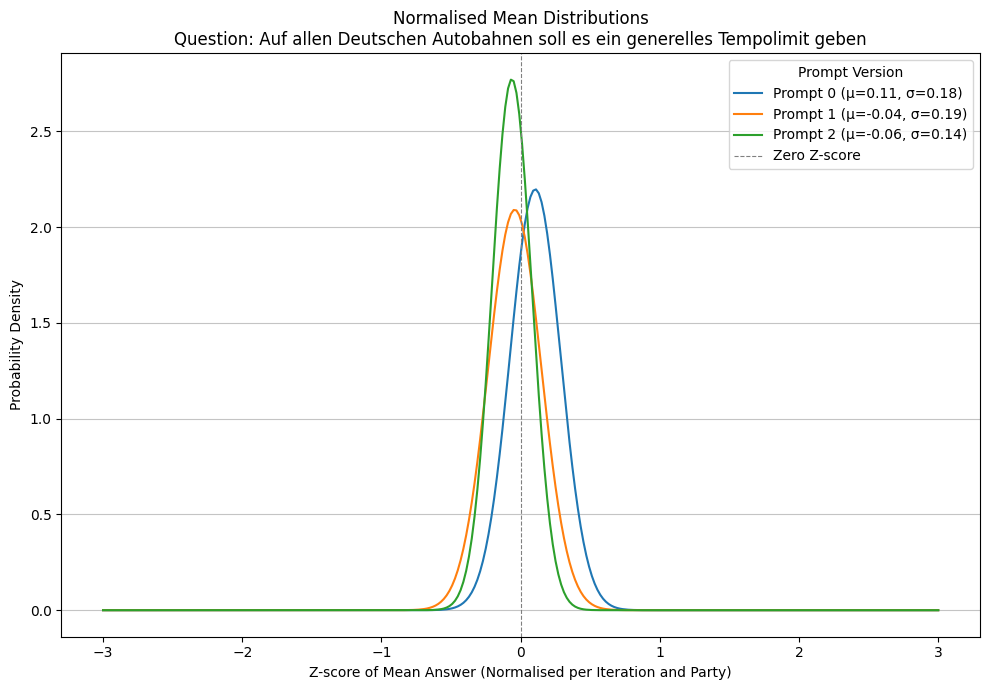

Prompt 0 (Prompt 0): p = 0.0127
  -> Reject normality (not normally distributed)
Prompt 1 (Prompt 1): p = 0.7544
  -> Fail to reject normality (likely normal)
Prompt 2 (Prompt 2): p = 0.2390
  -> Fail to reject normality (likely normal)
Kruskal-Wallis test: p = 0.0000
Kruskal-Wallis test result:
25.99747298244537
  -> Significant difference between at least two prompt versions


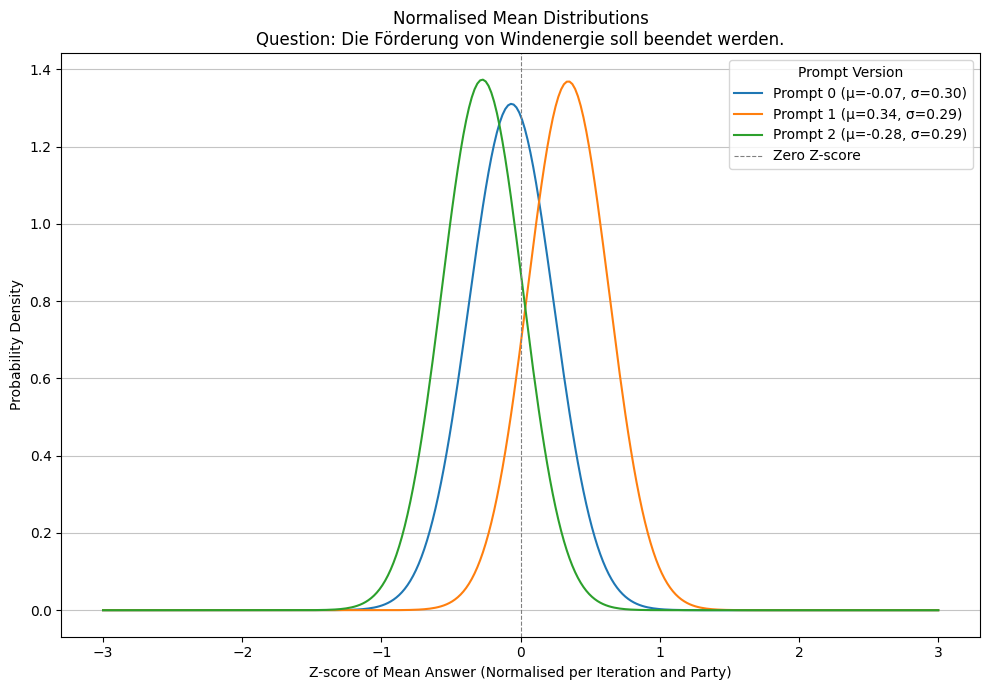

Prompt 0 (Prompt 0): p = 0.0012
  -> Reject normality (not normally distributed)
Prompt 1 (Prompt 1): p = 0.2053
  -> Fail to reject normality (likely normal)
Prompt 2 (Prompt 2): p = 0.0005
  -> Reject normality (not normally distributed)
Kruskal-Wallis test: p = 0.0000
Kruskal-Wallis test result:
55.567307344815354
  -> Significant difference between at least two prompt versions


In [9]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import kruskal


from scipy.stats import normaltest


prompt_labels = {
    0: "Prompt 0",
    1: "Prompt 1",
    2: "Prompt 2"
}

for question in plot_df["question_index"].unique():
    normalised_df = {0: [], 1: [], 2: []}
    aggregated_means = plot_df[plot_df["question_index"] == question].copy()

    for time in aggregated_means["time"].unique():
        for party in aggregated_means["party"].unique():
            iteration_data = aggregated_means[
                (aggregated_means["time"] == time) &
                (aggregated_means["party"] == party)
            ].copy()

            scaler = StandardScaler()
            scaler.fit(iteration_data[["answer"]].values.reshape(-1, 1))

            for prompt_v in range(3):
                mean = np.mean(
                    iteration_data[iteration_data["version"] == prompt_v]["answer"]
                )
                z_score = scaler.transform(np.array([[mean]]))[0][0]
                normalised_df[prompt_v].append(z_score)

    # Plotting normal distributions
    plt.figure(figsize=(10, 7))
    x = np.linspace(-3, 3, 300)

    for prompt_v in sorted(normalised_df.keys()):
        data = normalised_df[prompt_v]
        mu = np.mean(data)
        sigma = np.std(data)
        y = norm.pdf(x, mu, sigma)
        plt.plot(x, y, label=f"{prompt_labels[prompt_v]} (μ={mu:.2f}, σ={sigma:.2f})")

    plt.axvline(
        0, color="grey", linestyle="--", linewidth=0.8, label="Zero Z-score"
    )
    plt.title(f"Normalised Mean Distributions\nQuestion: {QUESTIONS[int(question)]}")
    plt.xlabel("Z-score of Mean Answer (Normalised per Iteration and Party)")
    plt.ylabel("Probability Density")
    plt.legend(title="Prompt Version")
    plt.grid(axis="y", alpha=0.75)
    plt.tight_layout()
    plt.show()

    for prompt_v, values in normalised_df.items():
        stat, p = normaltest(values)
        print(f"Prompt {prompt_v} ({prompt_labels[prompt_v]}): p = {p:.4f}")
        if p < 0.05:
            print("  -> Reject normality (not normally distributed)")
        else:
            print("  -> Fail to reject normality (likely normal)")

    stat, p = kruskal(*[normalised_df[prompt_v] for prompt_v in range(3)])
    print(f"Kruskal-Wallis test: p = {p:.4f}")
    print("Kruskal-Wallis test result:")    
    print(stat)
    if p < 0.05:
        print("  -> Significant difference between at least two prompt versions")
    else:
        print("  -> No significant difference")



     party debate_with  version  question_index  repetition  time  answer
0  CDU/CSU         AfD      0.0               0           0     0       4
1      AfD     CDU/CSU      0.0               0           0     0       3
2  CDU/CSU         AfD      0.0               0           1     0       4
3      AfD     CDU/CSU      0.0               0           1     0       3
4  CDU/CSU         AfD      0.0               0           2     0       4
Z-scores for version 0: [-0.5147762110250382, -0.5147762110250382, -0.5147762110250382, -0.5147762110250382, -0.5147762110250382, -0.5147762110250382, -0.5147762110250382, -0.5147762110250382, -0.5147762110250382, -0.5147762110250382, 1.7731180601973575, -0.5147762110250382, -0.5147762110250382, -0.5147762110250382, -0.5147762110250382, -0.5147762110250382, 1.7731180601973575, 1.7731180601973575, -0.5147762110250382, 1.7731180601973575, -0.5147762110250382, -0.5147762110250382, 1.7731180601973575, 1.7731180601973575, 1.7731180601973575, -0.5147762110

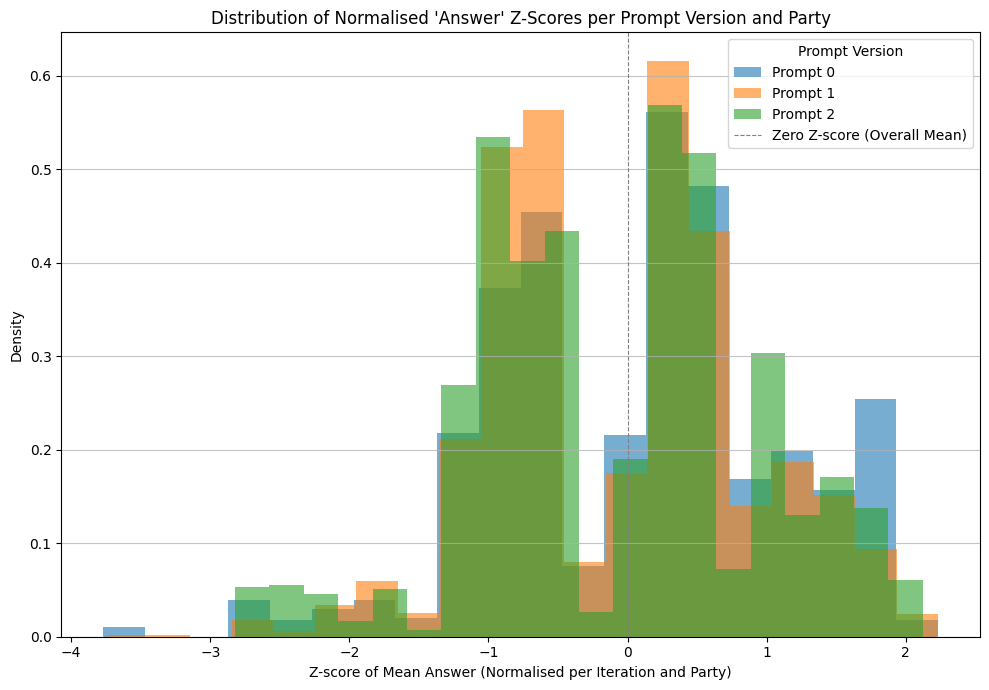

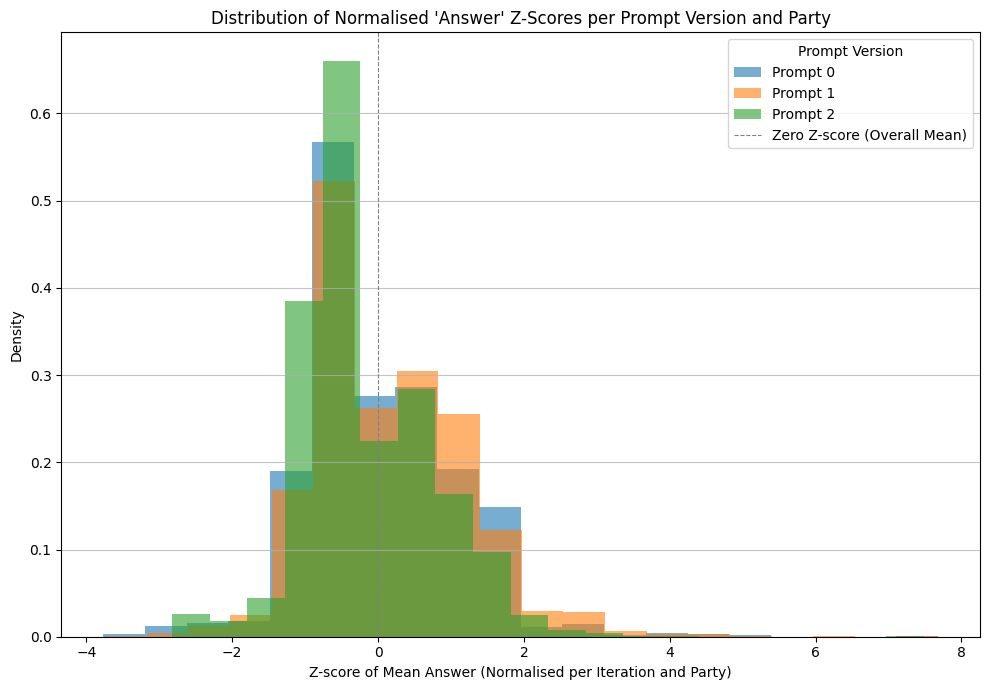

In [10]:
aggregated_means = plot_df.copy()

# Create an empty dictionary to store normalised data for each version
normalised_df = {0: [], 1: [], 2: []}


print(aggregated_means.head())

for  question in plot_df["question_index"].unique():

    for time in aggregated_means["time"].unique():
        for party in aggregated_means["party"].unique():
            # Filter data for the current repetition and party
            iteration_data = aggregated_means[
                (aggregated_means["question_index"] == question)
                & (aggregated_means["time"] == time)
                & (aggregated_means["party"] == party)
            ].copy()

            # Fit StandardScaler on the 'mean_answer' for this iteration
            scaler = StandardScaler()
            # Reshape to 2D array as StandardScaler expects this
            scaler.fit(iteration_data[["answer"]].values.reshape(-1, 1))

            for prompt_v in range(3):
                # Filter data for the current version
                data_for_version = iteration_data[
                    iteration_data["version"] == prompt_v
                ]
                

                z_scores: list = scaler.transform(data_for_version["answer"].values.reshape(-1, 1)).flatten().tolist()
                print(f"Z-scores for version {prompt_v}: {z_scores}")

                normalised_df[prompt_v].extend(z_scores)



    # plot data
    plt.figure(figsize=(10, 7))
    # Ensure versions are sorted for consistent plotting
    versions_sorted = sorted(normalised_df.keys())
    for version_str in versions_sorted:
        # Extract the numeric part of the version string (e.g., 'out_0' -> 0)
        prompt_v = version_str

        # Filter data for the current version
        version_data = normalised_df[prompt_v]
        print(f"length of version_data for {version_str}: {len(version_data)}")

        plt.hist(
            version_data,
            bins=20,  # You can adjust the number of bins
            alpha=0.6,  # Transparency to see overlaps
            label=prompt_labels[prompt_v],
            density=True,  # Normalise to form a probability density
            histtype="stepfilled",  # A nice style for multiple histograms
        )
    plt.axvline(
        0, color="grey", linestyle="--", linewidth=0.8, label="Zero Z-score (Overall Mean)"
    )  # Add a line at 0 for reference
    plt.title("Distribution of Normalised 'Answer' Z-Scores per Prompt Version and Party")
    plt.xlabel("Z-score of Mean Answer (Normalised per Iteration and Party)")
    plt.ylabel("Density")
    plt.legend(title="Prompt Version")
    plt.grid(axis="y", alpha=0.75)
    plt.tight_layout()

# calculating Anova at T20

In [11]:
# Perform ANOVA for each question
for question_index in QUESTION_INDICES:
    print(f"ANOVA for question {question_index}: {QUESTIONS[question_index]}")

    question_data = formatted_df_non_abs[
        formatted_df_non_abs["question_index"] == question_index
    ]

    if question_data.empty:
        print("No data available for this question.")
        continue

    # Fit OLS model
    model = ols(
        "T20 ~ C(version)*C(party) + C(debate_with)",
        data=question_data
    ).fit()

    # Get ANOVA table
    anova_table = anova_lm(model, typ=2)  # typ=2 is common for factorial designs
    print(anova_table)




ANOVA for question 0: Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben
                         sum_sq     df           F         PR(>F)
C(version)             8.673810    2.0    6.254895   2.014749e-03
C(party)             623.421958    6.0  149.854922  7.620086e-128
C(debate_with)        31.971958    6.0    7.685253   4.764435e-08
C(version):C(party)   18.426190   12.0    2.214596   9.699406e-03
Residual             563.703042  813.0         NaN            NaN
ANOVA for question 3: Die Förderung von Windenergie soll beendet werden.
                         sum_sq     df          F        PR(>F)
C(version)            36.092857    2.0  38.220246  1.367062e-16
C(party)             231.951323    6.0  81.874341  4.303828e-80
C(debate_with)        32.351323    6.0  11.419393  2.769195e-12
C(version):C(party)   62.623810   12.0  11.052498  1.178154e-20
Residual             383.873677  813.0        NaN           NaN


In [12]:
party_df_non_abs

,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,T0,4
1,AfD,CDU/CSU,0.0,0.0,0,T0,3
2,CDU/CSU,AfD,0.0,0.0,1,T0,4
3,AfD,CDU/CSU,0.0,0.0,1,T0,3
4,CDU/CSU,AfD,0.0,0.0,2,T0,4
...,...,...,...,...,...,...,...
10075,CDU/CSU,FDP,2.0,3.0,2,T20,1
10076,FDP,CDU/CSU,2.0,3.0,3,T20,1
10077,CDU/CSU,FDP,2.0,3.0,3,T20,1
10078,FDP,CDU/CSU,2.0,3.0,4,T20,1


In [13]:
# LMM - Linearly Mixed Model
# Model: answer ~ iteration + party + version, random intercept for agent_idx within party


# Prepare the main dataframe for LMM once, outside the loop
lmm_data = party_df_non_abs.copy()
lmm_data = lmm_data.dropna(subset=["answer"]).reset_index(drop=True)
lmm_data["answer"] = pd.to_numeric(lmm_data["answer"], errors="coerce")
# map from 0,4,8,12,16,20 to 0,1,2,3,4,5
lmm_data["time"] = lmm_data["time"].str.replace("T", "").astype(int)
lmm_data["time"] = lmm_data["time"].apply(
    lambda x: x / 4 if pd.notna(x) else np.nan
)
lmm_data["time"] = pd.to_numeric(lmm_data["time"], errors="coerce")
lmm_data["question_index"] = lmm_data["question_index"].astype("category")
lmm_data["party"] = lmm_data["party"].astype("category")
lmm_data["party"] = lmm_data["party"].cat.reorder_categories(
    ["keine Partei", "AfD", "Bündnis 90/Die Grünen", "CDU/CSU", "Die Linke", "FDP", "SPD"],
    ordered=False
)
lmm_data["debate_with"] = lmm_data["debate_with"].astype("category")
lmm_data = lmm_data.reset_index(drop=True)


display(lmm_data)



for question_index in lmm_data["question_index"].unique():
    for prompt_version in lmm_data["version"].unique():
        print(f"Processing version: {prompt_version}")

        # Filter the data for the current version
        version_data = lmm_data[(lmm_data["version"] == prompt_version) & (lmm_data["question_index"] == question_index)].copy()

        # Define groups for this subset of data
        groups = (
            version_data["party"].astype(str)
            + "_"
            + version_data["debate_with"].astype(str)
            + "_"
            + version_data["repetition"].astype(str)
        )

        md = smf.mixedlm(
            "answer ~ C(party) * time",
            version_data,
            groups=groups,
        )
        mdf = md.fit()
        print(mdf.summary())

,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,0.0,4
1,AfD,CDU/CSU,0.0,0.0,0,0.0,3
2,CDU/CSU,AfD,0.0,0.0,1,0.0,4
3,AfD,CDU/CSU,0.0,0.0,1,0.0,3
4,CDU/CSU,AfD,0.0,0.0,2,0.0,4
...,...,...,...,...,...,...,...
10075,CDU/CSU,FDP,2.0,3.0,2,5.0,1
10076,FDP,CDU/CSU,2.0,3.0,3,5.0,1
10077,CDU/CSU,FDP,2.0,3.0,3,5.0,1
10078,FDP,CDU/CSU,2.0,3.0,4,5.0,1


Processing version: 0.0
                      Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         answer    
No. Observations:           1680            Method:                     REML      
No. Groups:                 245             Scale:                      0.3495    
Min. group size:            6               Log-Likelihood:             -1792.0459
Max. group size:            12              Converged:                  Yes       
Mean group size:            6.9                                                   
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               5.195    0.129  40.166 0.000  4.941  5.448
C(party)[T.AfD]                        -2.064    0.183 -11.282 0.000 -2.422 -1.705
C(p

# First Effect Model 

In [14]:

for question_index in lmm_data["question_index"].unique():
    print(f"Processing question index: {question_index}")

    # Filter the data for the current question index
    question_data: pd.DataFrame = lmm_data[lmm_data["question_index"] == question_index].copy()
    question_data = question_data.reset_index(drop=True)


    # Define groups for this subset of data
    groups = (
        question_data["party"].astype(str)
        + "_"
        + question_data["debate_with"].astype(str)
        + "_"
        + question_data["repetition"].astype(str)
        + "_"
        + question_data["version"].astype(str)
    )

    # Full model: includes version
    full_model = smf.mixedlm(
        "answer ~ time + party + version",
        question_data,
        groups=groups
    ).fit()  
    print(full_model.summary())


Processing question index: 0.0
                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       answer    
No. Observations:       5040          Method:                   REML      
No. Groups:             735           Scale:                    0.3037    
Min. group size:        6             Log-Likelihood:           -5021.1189
Max. group size:        12            Converged:                Yes       
Mean group size:        6.9                                               
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       5.526    0.075  73.848 0.000  5.379  5.672
party[T.AfD]                   -2.245    0.095 -23.656 0.000 -2.431 -2.059
party[T.Bündnis 90/Die Grünen] -1.060    0.095 -11.168 0.000 -1.246 -0.874
party[T.CDU/C

In [15]:


groups = (
    lmm_data["party"].astype(str)
    + "_"
    + lmm_data["debate_with"].astype(str)
    + "_"
    + lmm_data["repetition"].astype(str)
    + "_"
    + lmm_data["version"].astype(str)
)


# Full model: includes version
full_model = smf.mixedlm(
    "answer ~ time * question_index * party * version",
    lmm_data,
    groups=groups
).fit(reml=False)  # Use ML for LRT

print(full_model.summary())


# Reduced model: drop 'version' completely
reduced_model = smf.mixedlm(
    "answer ~ time * question_index * party",
    lmm_data,
    groups=groups
).fit(reml=False)

# LRT statistic
lr_stat = 2 * (full_model.llf - reduced_model.llf)

# Degrees of freedom = difference in number of parameters
df_diff = full_model.df_modelwc - reduced_model.df_modelwc

# p-value
p_value = stats.chi2.sf(lr_stat, df_diff)

print(f"LRT statistic: {lr_stat:.2f}")
print(f"df difference: {df_diff}")
print(f"p-value: {p_value:.4f}")



                                    Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  answer     
No. Observations:                   10080                    Method:                              ML         
No. Groups:                         735                      Scale:                               0.6138     
Min. group size:                    12                       Log-Likelihood:                      -12218.9261
Max. group size:                    24                       Converged:                           Yes        
Mean group size:                    13.7                                                                     
-------------------------------------------------------------------------------------------------------------
                                                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------

# Distance from Initial Opinion 
In the following I'll be answering RQ2: "Does discussion cause agents' opinions to significantly shift from their starting points and converge towards more uniform stances?" by calculting the distance from the original opinion

In [16]:
lmm_data

,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,0.0,4
1,AfD,CDU/CSU,0.0,0.0,0,0.0,3
2,CDU/CSU,AfD,0.0,0.0,1,0.0,4
3,AfD,CDU/CSU,0.0,0.0,1,0.0,3
4,CDU/CSU,AfD,0.0,0.0,2,0.0,4
...,...,...,...,...,...,...,...
10075,CDU/CSU,FDP,2.0,3.0,2,5.0,1
10076,FDP,CDU/CSU,2.0,3.0,3,5.0,1
10077,CDU/CSU,FDP,2.0,3.0,3,5.0,1
10078,FDP,CDU/CSU,2.0,3.0,4,5.0,1


In [17]:
bla = formatted_df.copy()

# remove columns with missing values
bla = bla.dropna(axis=1, how="any")

# Calculate distance from initial opinion for each timepoint
for t in ["T0", "T4", "T8", "T12", "T16", "T20"]:
    bla[f"d{t[1:]}"] = abs(bla[t] - bla["T0"])

# Optionally, also include d0 (which is always zero)
#bla["d0"] = 0
display(bla)


,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20,d0,d4,d8,d12,d16,d20
0,CDU/CSU,AfD,0,0.0,0.0,4,5,6,6,6,6,0,1,2,2,2,2
1,AfD,CDU/CSU,0,0.0,0.0,3,3,3,3,3,3,0,0,0,0,0,0
2,CDU/CSU,AfD,1,0.0,0.0,4,5,6,6,5,6,0,1,2,2,1,2
3,AfD,CDU/CSU,1,0.0,0.0,3,3,3,3,3,3,0,0,0,0,0,0
4,CDU/CSU,AfD,2,0.0,0.0,4,6,5,5,6,5,0,2,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,CDU/CSU,FDP,2,3.0,2.0,5,2,1,2,2,1,0,3,4,3,3,4
1676,FDP,CDU/CSU,3,3.0,2.0,2,1,1,1,1,1,0,1,1,1,1,1
1677,CDU/CSU,FDP,3,3.0,2.0,4,1,1,1,1,1,0,3,3,3,3,3
1678,FDP,CDU/CSU,4,3.0,2.0,2,1,1,1,1,1,0,1,1,1,1,1


Plotting for question index 0.0 and version 0.0
Offset for version 0.0 and question index 0.0:
Offset index: 0
-0.2
Plotting for question index 3.0 and version 0.0
Offset for version 0.0 and question index 3.0:
Offset index: 1
-0.12000000000000001
Plotting for question index 0.0 and version 1.0
Offset for version 1.0 and question index 0.0:
Offset index: 2
-0.04000000000000001
Plotting for question index 3.0 and version 1.0
Offset for version 1.0 and question index 3.0:
Offset index: 3
0.03999999999999998
Plotting for question index 0.0 and version 2.0
Offset for version 2.0 and question index 0.0:
Offset index: 4
0.12
Plotting for question index 3.0 and version 2.0
Offset for version 2.0 and question index 3.0:
Offset index: 5
0.2


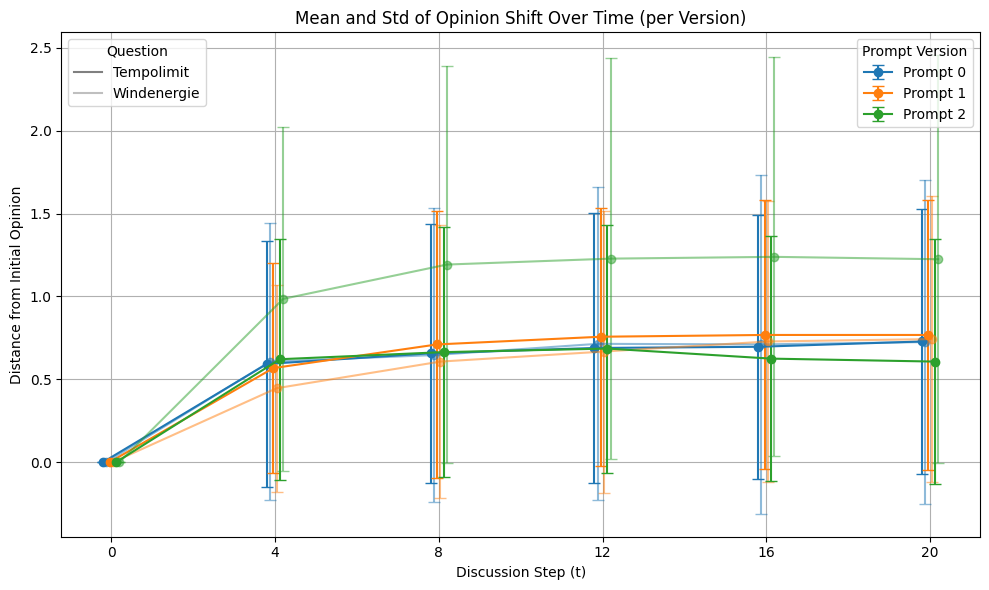

In [18]:
timepoints = ["d0", "d4", "d8", "d12", "d16", "d20"]
prompt_versions  = bla["version"].unique()
offsets = np.linspace(-0.2, 0.2, len(prompt_versions) * len(QUESTION_INDICES))  # Offset for each version and question index

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
opaqueness = [1, 0.5]



# ...existing code...
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Store handles for legends
prompt_handles = []
question_handles = []

for i, version in enumerate(prompt_versions):
    question_counter = 0
    for question_index in bla["question_index"].unique():
        print(f"Plotting for question index {question_index} and version {version}")
        version_data = bla[(bla["version"] == version) & (bla["question_index"] == question_index)]
        means = [version_data[tp].mean() for tp in timepoints]
        stds = [version_data[tp].std() for tp in timepoints]

        offset_i = i * len(QUESTION_INDICES) + question_counter
        print(f"Offset for version {version} and question index {question_index}:")
        print(f"Offset index: {offset_i}")
        print(offsets[int(offset_i)])

        x_vals = (
            np.array([int(tp[1:]) if tp != "d0" else 0 for tp in timepoints]) + offsets[int(offset_i)]
        )
        line = ax.errorbar(
            x_vals, means, yerr=stds, marker="o", capsize=4,
            label=f"Prompt {i}", color=colors[i], alpha=opaqueness[question_counter]
        )
        if question_counter == 0:
            prompt_handles.append(line)
        if i == 0:
            # Dummy lines for question legend
            dummy, = ax.plot([], [], color="gray", alpha=opaqueness[question_counter], label=f"Question {question_index}")
            question_handles.append(dummy)
        question_counter += 1

plt.xticks([0,  4, 8, 12, 16, 20])
plt.xlabel("Discussion Step (t)")
plt.ylabel("Distance from Initial Opinion")
plt.title("Mean and Std of Opinion Shift Over Time (per Version)")
plt.grid(True)

# First legend: Prompt Version (color)
legend1 = ax.legend(prompt_handles, [f"Prompt {i}" for i in range(len(prompt_versions))], title="Prompt Version", loc="upper right")
ax.add_artist(legend1)

# Second legend: Question (opaqueness)
legend2 = ax.legend(question_handles, [QUESTIONS_SHORT[int(q)] for q in bla["question_index"].unique()], title="Question", loc="upper left")

plt.tight_layout()
plt.show()
# ...existing code...

In [19]:
# flatten the data so instead of having d0, d4, d8, d12, d16, d20 as columns, we have a single column for distance and a column for time
xx = []
for version_label, df in enumerate(bla.groupby("version")):
    version_df = df[1]
    version_df = version_df.melt(
        id_vars=["party", "debate_with", "repetition", "version", "question_index"],
        value_vars=[f"d{t[1:]}" for t in timepoints],
        var_name="time",
        value_name="distance"
    )
    version_df["time"] = version_df["time"].str.replace("d", "").astype(int)
    version_df["version"] = version_label
    xx.append(version_df)
# Concatenate all versions into a single DataFrame

formatted_df_distance = pd.concat(xx, ignore_index=True)

formatted_df_distance

,party,debate_with,repetition,version,question_index,time,distance
0,CDU/CSU,AfD,0,0,0.0,0,0
1,AfD,CDU/CSU,0,0,0.0,0,0
2,CDU/CSU,AfD,1,0,0.0,0,0
3,AfD,CDU/CSU,1,0,0.0,0,0
4,CDU/CSU,AfD,2,0,0.0,0,0
...,...,...,...,...,...,...,...
10075,CDU/CSU,FDP,2,2,3.0,20,4
10076,FDP,CDU/CSU,3,2,3.0,20,1
10077,CDU/CSU,FDP,3,2,3.0,20,3
10078,FDP,CDU/CSU,4,2,3.0,20,1


In [20]:
formatted_df_distance["party"] = formatted_df_distance["party"].astype("category")
formatted_df_distance["party"] = formatted_df_distance["party"].cat.reorder_categories(
    [
        "keine Partei",
        "AfD",
        "Bündnis 90/Die Grünen",
        "CDU/CSU",
        "Die Linke",
        "FDP",
        "SPD",
    ],
    ordered=False,
)
formatted_df_distance["version"] = formatted_df_distance["version"].astype("category")

print(formatted_df_distance.head())

formatted_df_distance = formatted_df_distance[
    formatted_df_distance["time"] != 0
]  # Remove d0, as it is always zero

# mixed effects model for distance from initial opinion
groups = (
    formatted_df_distance["party"].astype(str)
    + "_"
    + formatted_df_distance["debate_with"].astype(str)
    + "_"
    + formatted_df_distance["repetition"].astype(str)
    + "_"
    + formatted_df_distance["version"].astype(str)
    + "_"
    + formatted_df_distance["question_index"].astype(str)
)
md = smf.mixedlm(
    "distance ~ time  + C(party) + time* C(version)",
    formatted_df_distance,
    groups=groups,
)
mdf = md.fit()
print(mdf.summary())

     party debate_with repetition version  question_index  time  distance
0  CDU/CSU         AfD          0       0             0.0     0         0
1      AfD     CDU/CSU          0       0             0.0     0         0
2  CDU/CSU         AfD          1       0             0.0     0         0
3      AfD     CDU/CSU          1       0             0.0     0         0
4  CDU/CSU         AfD          2       0             0.0     0         0
                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       distance  
No. Observations:         8400          Method:                   REML      
No. Groups:               1470          Scale:                    0.2624    
Min. group size:          5             Log-Likelihood:           -7992.7875
Max. group size:          10            Converged:                Yes       
Mean group size:          5.7                                               
-------------------------------------

In [21]:
for prompt_version in formatted_df_distance["version"].unique():
    print(f"Processing version: {prompt_version}")


    # Filter the data for the current version
    version_data = formatted_df_distance[formatted_df_distance["version"] == prompt_version].copy()


    # ensure that time = 0 is not included in the model (assert incase it is)
    assert (version_data["time"] != 0).all(), "Time = 0 should not be included in the model."

    # Define groups for this subset of data
    groups = (
        version_data["party"].astype(str)
        + "_"
        + version_data["debate_with"].astype(str)
        + "_"
        + version_data["repetition"].astype(str)
    )

    md = smf.mixedlm(
        "distance ~ time + C(party)",
        version_data,
        groups=groups,
    )
    mdf = md.fit()
    print(mdf.summary())

Processing version: 0
                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       distance  
No. Observations:         2800          Method:                   REML      
No. Groups:               245           Scale:                    0.4713    
Min. group size:          10            Log-Likelihood:           -3085.6452
Max. group size:          20            Converged:                Yes       
Mean group size:          11.4                                              
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.364    0.070  5.164 0.000  0.226  0.502
C(party)[T.AfD]                    1.059    0.092 11.534 0.000  0.879  1.239
C(party)[T.Bündnis 90/Die Grünen]  0.190    0.092  2.073 0.038  0.010  0.3

# Variance of opinions 

/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_27960/3482665505.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_df = pd.concat(


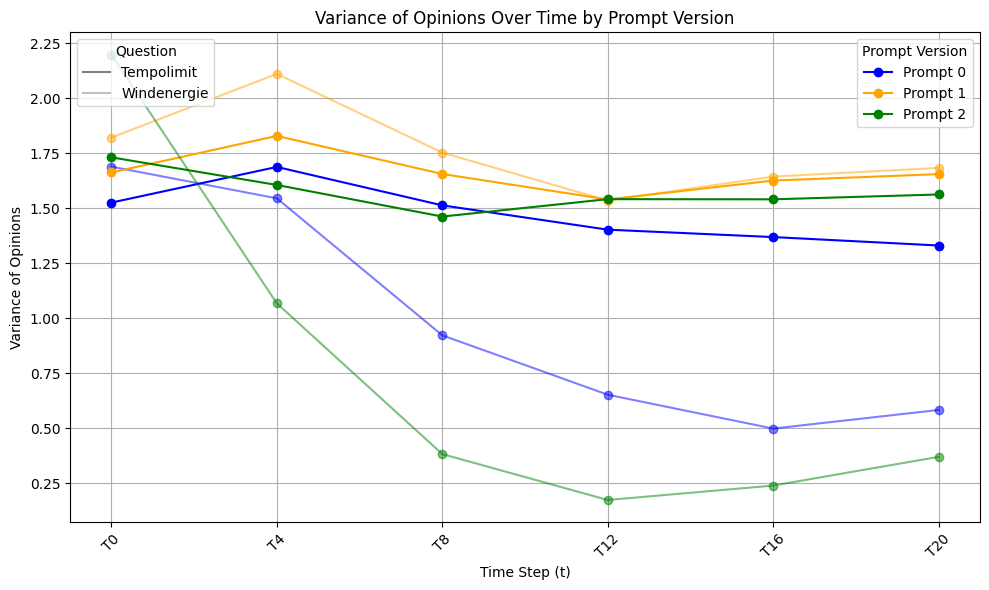

In [22]:
timesteps = [f"T{i}" for i in range(0, 21, 4)]
versions = bla["version"].unique()

variance_df = pd.DataFrame(columns=["version", "time", "variance", "question_index"])

for version in versions:
    for question_index in bla["question_index"].unique():
        for t in timesteps:
            # Filter for current version
            vals = bla[(bla["version"] == version) & (bla["question_index"] == question_index)][t]
            variance = vals.var()
            variance_df = pd.concat(
                [variance_df, pd.DataFrame({"version": [version], "time": [t], "variance": [variance], "question_index": [question_index]})],
                ignore_index=True
            )
# ...existing code...
colors = ["blue", "orange", "green"]
opaqueness = [1, 0.5, 0.8]  # Adjust opaqueness for each question

plt.figure(figsize=(10, 6))
ax = plt.gca()

# Store handles for legends
prompt_handles = []
question_handles = []

for version_idx, version in enumerate(versions):
    for question_cnt, question_index in enumerate(variance_df["question_index"].unique()):
        vdf = variance_df[(variance_df["version"] == version) & (variance_df["question_index"] == question_index)]
        line, = ax.plot(
            vdf["time"], vdf["variance"], marker="o",
            color=colors[version_idx], alpha=opaqueness[question_cnt],
            label=f"Prompt {version_idx} (Q{question_index})"
        )
        if question_cnt == 0:
            prompt_handles.append(line)
        if version_idx == 0:
            # Dummy lines for question legend
            dummy, = ax.plot([], [], color="gray", alpha=opaqueness[question_cnt], label=f"Question {question_index}")
            question_handles.append(dummy)

plt.xticks(timesteps, rotation=45)
plt.xlabel("Time Step (t)")
plt.ylabel("Variance of Opinions")
plt.title("Variance of Opinions Over Time by Prompt Version")

# First legend: Prompt Version (color)
legend1 = ax.legend(prompt_handles, [f"Prompt {i}" for i in range(len(colors))], title="Prompt Version", loc="upper right")
ax.add_artist(legend1)

# Second legend: Question (opaqueness)
legend2 = ax.legend(question_handles, [QUESTIONS_SHORT[int(q)] for q in variance_df["question_index"].unique()], title="Question", loc="upper left")

plt.grid(True)
plt.tight_layout()
plt.show()
# ...existing code...


In [23]:
from statsmodels.formula.api import ols

print(variance_df["time"].dtype)
if variance_df["time"].dtype != "int64":
    variance_df["time"] = variance_df["time"].str.replace("T", "").astype(float)
    variance_df["time"] = variance_df["time"].astype(int)

lm = ols("variance ~ time", data=variance_df, groups=variance_df["version"]).fit()
print(lm.summary())


object
                            OLS Regression Results                            
Dep. Variable:               variance   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     7.238
Date:                Thu, 24 Jul 2025   Prob (F-statistic):             0.0110
Time:                        15:55:09   Log-Likelihood:                -24.145
No. Observations:                  36   AIC:                             52.29
Df Residuals:                      34   BIC:                             55.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6829      0.144     11.697  

/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


In [24]:
for v in variance_df['version'].unique():
    for q in variance_df['question_index'].unique():
        variance_df_subset = variance_df[(variance_df['version'] == v) & (variance_df['question_index'] == q)].copy(    )
        print(variance_df_subset["time"].dtype)
        if variance_df_subset["time"].dtype != "int64":
            variance_df_subset["time"] = variance_df_subset["time"].astype(int)
        
        lm = ols("variance ~ time", data=variance_df_subset).fit()
        print(f"Linear regression summary for version {v} and question {QUESTIONS_SHORT[int(q)]}:")
        print(f"time p = {lm.pvalues['time']:.4f}")
    


int64
Linear regression summary for version 0.0 and question Tempolimit:
time p = 0.0411
int64
Linear regression summary for version 0.0 and question Windenergie:
time p = 0.0073
int64
Linear regression summary for version 1.0 and question Tempolimit:
time p = 0.3897
int64
Linear regression summary for version 1.0 and question Windenergie:
time p = 0.1875
int64
Linear regression summary for version 2.0 and question Tempolimit:
time p = 0.2377
int64
Linear regression summary for version 2.0 and question Windenergie:
time p = 0.0521
